In [10]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import random

In [7]:

LOAD_DIR = r'C:\Users\elefa\Documents\local_dir\local_python_code\mini_proj_data\modified_swiss_dwellings'
bid = '23'  # replace with an actual building ID
domain = np.load(join(LOAD_DIR, f'{bid}_domain.npy'))
interior = np.load(join(LOAD_DIR, f'{bid}_interior.npy'))

In [25]:
def visualize_floorplans(domain, interior):
    """
    Visualizes the floorplan domain and the interior mask.
    
    Parameters:
    - domain: 2D numpy array representing the floorplan domain.
    - interior: 2D numpy array representing the interior mask.
    """
    plt.figure(figsize=(10, 5))
    
    # Plotting the domain
    plt.subplot(1, 2, 1)
    plt.title("Initial Domain")
    plt.imshow(domain, cmap='hot')
    
    # Plotting the interior mask
    plt.subplot(1, 2, 2)
    plt.title("Interior Mask")
    plt.imshow(interior, cmap='gray')
    
    plt.tight_layout()
    plt.show()

def visualize_sim(u, bid):
    """
    Visualizes the simulation results.
    
    Parameters:
    - u: 2D numpy array representing the simulation results.
    - bid: str, building ID for the title.
    """
    plt.figure(figsize=(5, 5))
    plt.title(f"Simulation Results of Building {bid}")
    plt.imshow(u, cmap='hot')
    plt.colorbar(label='Temperature')
    plt.show()


SIMULATE FUNCTIONS 

In [ ]:
def load_data(load_dir, bid):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{bid}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{bid}_interior.npy"))
    return u, interior_mask


def jacobi(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)

    for i in range(max_iter):
        # Compute average of left, right, up and down neighbors, see eq. (1)
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = u_new[interior_mask]
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        u[1:-1, 1:-1][interior_mask] = u_new_interior

        if delta < atol:
            break
    return u


def summary_stats(u, interior_mask):
    u_interior = u[1:-1, 1:-1][interior_mask]
    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        'mean_temp': mean_temp,
        'std_temp': std_temp,
        'pct_above_18': pct_above_18,
        'pct_below_15': pct_below_15,
    }   

In [11]:
# DECIDE N
N = 10

In [23]:
with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
    building_ids = f.read().splitlines()

building_ids = random.sample(building_ids, N)

# Load floor plans
all_u0 = np.empty((N, 514, 514))
all_interior_mask = np.empty((N, 512, 512), dtype='bool')
for i, bid in enumerate(building_ids):
    u0, interior_mask = load_data(LOAD_DIR, bid)
    all_u0[i] = u0
    all_interior_mask[i] = interior_mask

# Run jacobi iterations for each floor plan
MAX_ITER = 20_000
ABS_TOL = 1e-4

all_u = np.empty_like(all_u0)
for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
    u = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)
    all_u[i] = u

# Print summary statistics in CSV format
stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
print('building_id, ' + ', '.join(stat_keys))  # CSV header
for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
    stats = summary_stats(u, interior_mask)
    print(f"{bid},", ", ".join(str(stats[k]) for k in stat_keys))

KeyboardInterrupt: 

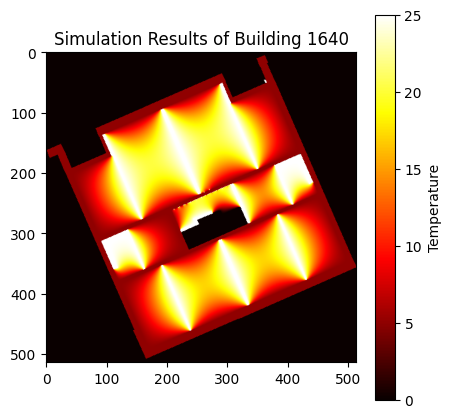

In [26]:
visualize_sim(u, bid)